In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (99.9 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-

In [2]:
import os
import gc
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray

from google.colab import drive
drive.mount('/content/drive')


RAW_DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data"
PROCESSED_DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/processed_data"
POS_DATA_DIR = os.path.join(PROCESSED_DATA_DIR, "positive")
NEG_DATA_DIR = os.path.join(PROCESSED_DATA_DIR, "negative")
MODEL_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/model"
RES_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/result"

Mounted at /content/drive


In [3]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im


def read_full_image(slide_num, level=6, ifmask=False):

  slide_name = f"Copy of tumor_{slide_num}.tif"
  tumor_mask_name = f"Copy of tumor_{slide_num}_mask.tif"

  slide_path = os.path.join(RAW_DATA_DIR, slide_name)
  tumor_mask_path = os.path.join(RAW_DATA_DIR, tumor_mask_name)

  if not ifmask:
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                            slide.level_dimensions[level][0], 
                                                            slide.level_dimensions[level][1]))
    slide_image = read_slide(
        slide, x=0, y=0, level=level, 
        width=slide.level_dimensions[level][0], 
        height=slide.level_dimensions[level][1]) 
    
    return slide_image

  else:
    tumor_mask = open_slide(tumor_mask_path)
    print ("Read WSI from %s with width: %d, height: %d" % (tumor_mask_path, 
                                                            tumor_mask.level_dimensions[level][0], 
                                                            tumor_mask.level_dimensions[level][1]))

    mask_image = read_slide(
        tumor_mask, x=0, y=0, level=level, 
        width=tumor_mask.level_dimensions[level][0], 
        height=tumor_mask.level_dimensions[level][1])[:,:,0]

    return mask_image

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


In [4]:
def get_center(slide_image, x_level, y_level, level=6, patch_len=299):
  assert 0 <= x_level + patch_len-1 <= slide_image.shape[0]
  assert 0 <= y_level + patch_len-1 <= slide_image.shape[1]
  assert 0 <= x_level <= slide_image.shape[0]
  assert 0 <= y_level <= slide_image.shape[1]

  factor = 2 ** level
  xc_level = x_level + patch_len//2
  yc_level = y_level + patch_len//2
  xc_0 = xc_level * factor
  yc_0 = yc_level * factor

  return xc_0, yc_0


def get_patch_from_center(slide_image, xc_0, yc_0, level=6, patch_len=299):
  factor = 2 ** level
  xc_level = xc_0 // factor
  yc_level = yc_0 // factor
  x_level = xc_level - patch_len//2
  y_level = yc_level - patch_len//2
  
  assert 0 <= x_level + patch_len-1 <= slide_image.shape[0]
  assert 0 <= y_level + patch_len-1 <= slide_image.shape[1]
  assert 0 <= x_level <= slide_image.shape[0]
  assert 0 <= y_level <= slide_image.shape[1]

  return slide_image[
        x_level: x_level + patch_len, y_level: y_level + patch_len]
        

def delete_gray(slide_image, threshold=0.4, show=False):
  tissue_pixels = find_tissue_pixels(slide_image)
  percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
  if show:
    print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
  
  if percent_tissue >= threshold:
    return True
  else:
    return False

def get_target(mask_region, patch_len=299, target_size=128):
  offset = (patch_len - target_size)//2
  target = mask_region[offset: offset+128, offset: offset+128]
  return 1.0 if target.sum() != 0 else 0.0

In [5]:
def get_patches_from_center(multi_slide_images, xc_0, yc_0, level_lst=[5,6,7], patch_len=299):
  multi_pitches = []
  for i, level in enumerate(level_lst):
    factor = 2 ** level
    xc_level = xc_0 // factor
    yc_level = yc_0 // factor

    x_level = xc_level - patch_len//2
    y_level = yc_level - patch_len//2

    slide_image = multi_slide_images[i]
    assert 0 <= x_level + patch_len-1 <= slide_image.shape[0]
    assert 0 <= y_level + patch_len-1 <= slide_image.shape[1]
    assert 0 <= x_level <= slide_image.shape[0]
    assert 0 <= y_level <= slide_image.shape[1]

    multi_pitches.append(slide_image[
        x_level: x_level + patch_len, y_level: y_level + patch_len])
    
  return multi_pitches

In [6]:
def allocate_ones(mask_image, patch_len=299):
  # Allocate ones
  allocated_ones = np.where(mask_image == 1)
  all_ones = list(zip(allocated_ones[0], allocated_ones[1]))
  print("The number of tumor pixels", len(all_ones))

  all_ones = [
      (x, y) for x, y in all_ones if (
          patch_len//2 < x < slide_image.shape[0]-patch_len//2) and (
              patch_len//2 < y < slide_image.shape[1]-patch_len//2)]
  random.shuffle(all_ones)
  print("The number of tumor pixels after filter", len(all_ones))
  return all_ones


def allocate_zeros(slide_image, mask_image, patch_len=299):
  tissue_pixels = find_tissue_pixels(slide_image)
  tissue_pixels = set(tissue_pixels)
  print("The number of tissue", len(tissue_pixels))

  allocated_ones = np.where(mask_image == 1)
  all_ones = list(zip(allocated_ones[0], allocated_ones[1]))
  all_ones = set(all_ones)
  print("The number of tumor", len(all_ones))

  tissue_pixels = list(tissue_pixels.difference(all_ones))
  print("The number of normal tissue", len(tissue_pixels))

  tissue_pixels = [
      (x, y) for x, y in tissue_pixels if (
          patch_len//2 < x < slide_image.shape[0]-patch_len//2) and (
              patch_len//2 < y < slide_image.shape[1]-patch_len//2)]
  random.shuffle(tissue_pixels)
  print("The number of normal tissue after filter", len(tissue_pixels))
  return tissue_pixels

In [7]:
# ["091", "101", "110", "016", "078", "031", "064"]

In [8]:
# file_name_lst = list(set(map(lambda x: re.findall(r'\d+', x)[0], os.listdir(RAW_DATA_DIR))))

# for slide_num in file_name_lst:
#   mask_image = read_full_image(slide_num, level=7, ifmask=True)
#   print("Total tumor area", mask_image.sum())
#   print("\n")

In [9]:
patch_len = 299

inception_zoom1 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(patch_len, patch_len, 3))

inception_zoom2 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(patch_len, patch_len, 3))

inception_zoom3 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(patch_len, patch_len, 3))

# freeze the inception model to increase training speed
inception_zoom1.trainable = False
inception_zoom2.trainable = False
inception_zoom3.trainable = False

# creat the base model
model_zoom1 = models.Sequential()
model_zoom1.add(inception_zoom1)
model_zoom1.add(layers.GlobalAveragePooling2D())

model_zoom2 = models.Sequential()
model_zoom2.add(inception_zoom2)
model_zoom2.add(layers.GlobalAveragePooling2D())

model_zoom3 = models.Sequential()
model_zoom3.add(inception_zoom3)
model_zoom3.add(layers.GlobalAveragePooling2D())

input_zoom1 = layers.Input(shape=(patch_len, patch_len, 3), name="input1")
input_zoom2 = layers.Input(shape=(patch_len, patch_len, 3), name="input2")
input_zoom3 = layers.Input(shape=(patch_len, patch_len, 3), name="input3")

encoded_zoom1 = model_zoom1(input_zoom1)
encoded_zoom2 = model_zoom2(input_zoom2)
encoded_zoom3 = model_zoom3(input_zoom3)

merged = layers.concatenate([encoded_zoom1, encoded_zoom2, encoded_zoom3])
dense1 = layers.Dense(256, activation='relu')(merged)
drop_layer = layers.Dropout(0.5)(dense1)
dense2 = layers.Dense(126, activation='relu')(drop_layer)

output = layers.Dense(1, activation='sigmoid')(dense2)
model = models.Model(inputs=[input_zoom1, input_zoom2, input_zoom3], outputs=output)

model.summary()

model.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input2 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input3 (InputLayer)            [(None, 299, 299, 3  0           []                               
                             

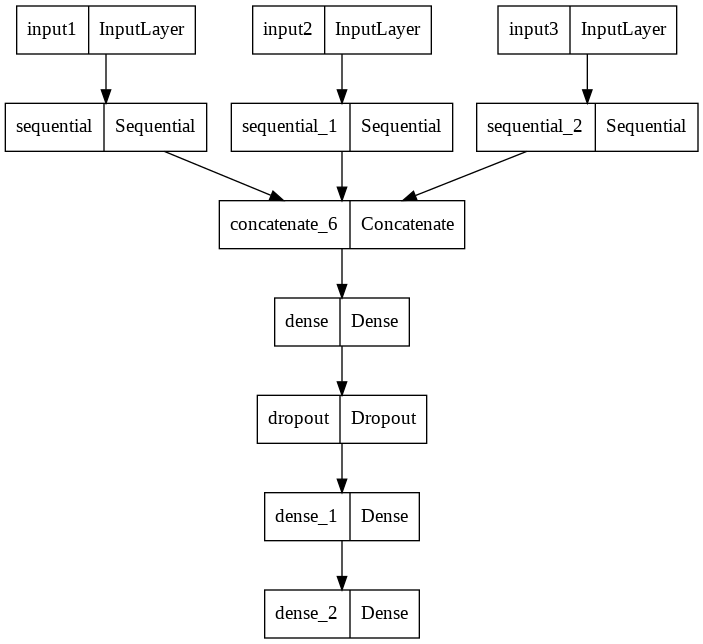

In [10]:
base_model_structure = os.path.join(MODEL_DIR, 'model_threezooms_357.png')
plot_model(model, to_file=base_model_structure)

In [11]:
train_file = ["101", "094", "110", "016", "078", "031", "064"]
test_file = ["091", "075", "094", "084"]

In [12]:
sampling_times = 10
nsamples = 200
level_lst = [3, 5, 7]
val_split = 0.3

In [13]:
train_loss_lst = []
train_accuracy_lst = []
val_loss_lst = []
val_accuracy_lst = []

In [14]:
def rotation_flip(image):
  temp = tf.image.rot90(image, k=np.random.choice([0, 1, 2, 3]))
  temp = tf.image.flip_left_right(temp)
  temp = tf.image.rot90(temp, k=np.random.choice([0, 1, 2, 3]))
  return temp


def color_augmentation(image, brightness=64/255, saturation=0.25, hue=0.04, contrast=0.75):
  temp = tf.image.random_brightness(image, max_delta=brightness, seed=0)
  temp = tf.image.random_saturation(temp, lower=0, upper=saturation, seed=0)
  temp = tf.image.random_hue(temp, max_delta=hue, seed=0)
  temp = tf.image.random_contrast(temp, lower=0, upper=contrast, seed=None)
  return temp


def list_map_data_aug(input_list):
  return list(
      map(lambda x: color_augmentation(rotation_flip(x)), input_list)
      )

In [ ]:
for s_i in range(sampling_times):

  for slide_num in train_file:
    print("\nStart Processing for", slide_num)
    multi_slide_images = []
    multi_mask_images = []
    for level in level_lst:
      slide_image = read_full_image(slide_num, level=level, ifmask=False)
      mask_image = read_full_image(slide_num, level=level, ifmask=True)
      multi_slide_images.append(slide_image)
      multi_mask_images.append(mask_image)

    all_ones = allocate_ones(multi_mask_images[-1])
    all_zeros = allocate_zeros(multi_slide_images[-1], multi_mask_images[-1])

    # Generate samples and train model
    neg_i = 0
    factor = 2 ** level_lst[-1]

    print("Sampling", s_i)
    start_ind = s_i * nsamples
    end_ind = (s_i+1) * nsamples

    if end_ind <= len(all_ones):

      # positive samples
      print("Generating positive samples......")
      pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_357_{s_i}.npy")

      if not os.path.exists(pos_file):
        print("------Process samples-------")
        selected_centers = all_ones[start_ind: end_ind]

        pos_pitch_lst = [[] for _ in range(len(level_lst))]
        for x_cen, y_cen in selected_centers:
          multi_check_images = get_patches_from_center(multi_mask_images, x_cen*factor, y_cen*factor, level_lst=level_lst)
          multi_tumor_regions = get_patches_from_center(multi_slide_images, x_cen*factor, y_cen*factor, level_lst=level_lst)
          assert multi_check_images[0].sum() != 0
          assert get_target(multi_check_images[0]) == 1.0

          for i in range(len(level_lst)):
            pos_pitch_lst[i].append(multi_tumor_regions[i] / 255.0)

        pos_pitch_lst = np.array(pos_pitch_lst)
        np.save(pos_file, pos_pitch_lst)

      else:
        print("------Load samples-------")
        pos_pitch_lst = np.load(pos_file)
      
      pos_pitch_lst = np.array(list(
            map(lambda x: list_map_data_aug(x), pos_pitch_lst)
            ))
      
      train_dataset = tf.data.Dataset.from_tensor_slices(
          ({'input1': np.array(pos_pitch_lst[0][int(val_split*nsamples) :]), 
            'input2': np.array(pos_pitch_lst[1][int(val_split*nsamples) :]),
            'input3': np.array(pos_pitch_lst[2][int(val_split*nsamples) :])}, 
          np.array([1.0] * nsamples)[int(val_split*nsamples) :])
          )

      val_dataset = tf.data.Dataset.from_tensor_slices(
          ({'input1': np.array(pos_pitch_lst[0][: int(val_split*nsamples)]), 
            'input2': np.array(pos_pitch_lst[1][: int(val_split*nsamples)]),
            'input3': np.array(pos_pitch_lst[2][: int(val_split*nsamples)])}, 
          np.array([1.0] * nsamples)[: int(val_split*nsamples)])
          )
      del pos_pitch_lst
      gc.collect()
      
      
      # negative samples
      print("Generating negative samples......")
      neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_357_{s_i}.npy")

      if not os.path.exists(neg_file):
        print("------Process samples-------")
        neg_pitch_lst = [[] for _ in range(len(level_lst))]

        while len(neg_pitch_lst[0]) < nsamples:
          x_cen, y_cen = all_zeros[neg_i]

          multi_tumor_regions = get_patches_from_center(multi_slide_images, x_cen*factor, y_cen*factor, level_lst=level_lst)

          # Make sure that minimum zoom level have enough tissue
          if delete_gray(multi_tumor_regions[0]):
            multi_check_images = get_patches_from_center(multi_mask_images, x_cen*factor, y_cen*factor, level_lst=level_lst)

            # Make sure that minimum zoom level have tumor
            label = get_target(multi_check_images[0])
            if label == 0.0:
              for i in range(len(level_lst)):
                neg_pitch_lst[i].append(multi_tumor_regions[i] / 255.0)
          neg_i += 1
    
        neg_pitch_lst = np.array(neg_pitch_lst)
        np.save(neg_file, neg_pitch_lst)

      else:
        print("------Load samples-------")
        neg_pitch_lst = np.load(neg_file)
      
      neg_pitch_lst = np.array(list(
            map(lambda x: list_map_data_aug(x), neg_pitch_lst)
            ))

      train_dataset = train_dataset.concatenate(
          tf.data.Dataset.from_tensor_slices(
              ({'input1': np.array(neg_pitch_lst[0][int(val_split*nsamples) :]), 
                'input2': np.array(neg_pitch_lst[1][int(val_split*nsamples) :]),
                'input3': np.array(neg_pitch_lst[2][int(val_split*nsamples) :])}, 
              np.array([0.0] * nsamples)[int(val_split*nsamples) :])
              )
            )
      
      val_dataset = val_dataset.concatenate(
          tf.data.Dataset.from_tensor_slices(
              ({'input1': np.array(neg_pitch_lst[0][: int(val_split*nsamples)]), 
                'input2': np.array(neg_pitch_lst[1][: int(val_split*nsamples)]),
                'input3': np.array(neg_pitch_lst[2][: int(val_split*nsamples)])}, 
            np.array([0.0] * nsamples)[: int(val_split*nsamples)])
              )
          )
      del neg_pitch_lst
      gc.collect()   

      # Prepare dataset
      print("Prepare dataset......")
      BATCH_SIZE = 64
      SHUFFLE_BUFFER_SIZE = int(nsamples*2*(1-val_split))
      train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      
      BATCH_SIZE = 64
      SHUFFLE_BUFFER_SIZE = int(nsamples*2*val_split)
      val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

      print("Train model......")
      checkpoint_path = os.path.join(MODEL_DIR, "model_357_200.ckpt")
      cp_callback = tf.keras.callbacks.ModelCheckpoint(
          filepath=checkpoint_path, save_weights_only=True, verbose=1)
      
      history = model.fit(train_dataset, validation_data=val_dataset, epochs=2, callbacks=[cp_callback])

      del train_dataset, val_dataset
      gc.collect() 

      train_loss_lst.extend(history.history["loss"])
      train_accuracy_lst.extend(history.history["binary_accuracy"])
      val_loss_lst.extend(history.history["val_loss"])
      val_accuracy_lst.extend(history.history["val_binary_accuracy"])

      res_df = pd.DataFrame({
          "train_loss_lst": train_loss_lst,
          "train_accuracy_lst": train_accuracy_lst,
          "val_loss_lst": val_loss_lst,
          "val_accuracy_lst": val_accuracy_lst
      })
      res_file = os.path.join(RES_DIR, "res_357_200.csv")
      res_df.to_csv(res_file, index=False)




Start Processing for 101
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101.tif with width: 17408, height: 8960
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101_mask.tif with width: 17408, height: 8960
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101.tif with width: 4352, height: 2240
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101_mask.tif with width: 4352, height: 2240
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101.tif with width: 1088, height: 560
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101_mask.tif with width: 1088, height: 560
The number of tumor pixels 11756
The number of tumor pixels after filter 6350
The number of tissue 150818
The number of tumor 11756
The number of normal tissue 139078
The number of normal tissue af

In [ ]:
res_df

,train_loss_lst,train_accuracy_lst,val_loss_lst,val_accuracy_lst
0,1.105659,0.507143,0.562401,0.625000
1,0.555649,0.742857,0.379978,0.875000
2,0.721736,0.603571,0.613571,0.625000
3,0.648522,0.675000,0.437820,0.825000
4,0.748848,0.592857,0.630992,0.633333
...,...,...,...,...
135,0.308813,0.864286,0.226706,0.908333
136,0.304507,0.867857,0.168769,0.941667
137,0.236181,0.896429,0.214517,0.916667
138,0.426118,0.814286,0.282023,0.916667


In [ ]:
fig = px.line(
    res_df, 
    x=range(len(res_df)), 
    y=["train_loss_lst", "val_loss_lst"], 
    markers=True)
fig.show()

In [ ]:
fig = px.line(
    res_df, 
    x=range(len(res_df)), 
    y=["train_accuracy_lst", "val_accuracy_lst"], 
    markers=True)
fig.show()

In [15]:
checkpoint_path = os.path.join(MODEL_DIR, "model_357_200.ckpt")
# Loads the weights
model.load_weights(checkpoint_path)

In [16]:
def label_prediction(x, y, predict_mask, label=1.0, patch_len=299, target_size=128):
  offset = (patch_len - target_size)//2
  x_target = x + offset
  y_target = y + offset

  target_area = predict_mask[x_target: x_target+target_size, y_target: y_target+target_size]
  assert target_area.shape[0] == target_size

  predict_mask[x_target: x_target+target_size, y_target: y_target+target_size] = label

  return predict_mask

In [17]:
def label_heatmap_multizooms(
    multi_slide_images, multi_mask_images, predict_mask, 
    threshold=0.5, step=10, pred_level=5, patch_len=299, 
    show_res=True, verbose=0):

  x_scan = 0
  while x_scan <= multi_slide_images[-1].shape[0] - patch_len:
    
    y_scan = 0
    while y_scan <= multi_slide_images[-1].shape[1] - patch_len:
      
      xc_0, yc_0 = get_center(slide_image, x_scan, y_scan, level=level)
      
      factor = 2 ** pred_level
      xc_level = xc_0 // factor
      yc_level = yc_0 // factor
      x_level = xc_level - patch_len//2
      y_level = yc_level - patch_len//2

      assert 0 <= x_level + patch_len-1 <= multi_slide_images[0].shape[0]
      assert 0 <= y_level + patch_len-1 <= multi_slide_images[0].shape[1]
      assert 0 <= x_level <= multi_slide_images[0].shape[0]
      assert 0 <= y_level <= multi_slide_images[0].shape[1]

      multi_tumor_regions = get_patches_from_center(multi_slide_images, xc_0, yc_0, level_lst=level_lst)
      
      if delete_gray(multi_tumor_regions[0]):
        multi_tumor_regions = [region / 255.0 for region in multi_tumor_regions]

        input_data = {
            "input1": np.array([multi_tumor_regions[0]]), 
            "input2": np.array([multi_tumor_regions[1]]),
            "input3": np.array([multi_tumor_regions[2]])
            }
        pred = model.predict(input_data, verbose=verbose)
        pred_label = (pred > threshold).astype("int32")

        if show_res:
          multi_check_images = get_patches_from_center(multi_mask_images, xc_0, yc_0, level_lst=level_lst)
          label = get_target(multi_check_images[0])
          if label == 1:
            print(label, pred)

        if pred_label[0][0] == 1:
          predict_mask = label_prediction(x_level, y_level, predict_mask, label=1)
        else:
          predict_mask = label_prediction(x_level, y_level, predict_mask, label=0)

      y_scan += step
    x_scan += step

  return predict_mask


In [18]:
train_file = ["101", "094", "110", "016", "078", "031", "064"]
test_file = ["091", "075", "094", "084"]


Label heatmap for 091
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 7680, height: 6720
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 7680, height: 6720
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 1920, height: 1680
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 1920, height: 1680
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 480, height: 420
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 480, height: 420
The shape of predict_mask (6720, 7680)
The number of tumor of predict_mask 0.0
1.0 [[0.8382089]]
1.0 [[0.41984528]]
1.0 [[0.28725195]]
1.0 [[0.5150422]]
1.0 [[0.9972451]]
1.0 [[0.9945904]]
1.0 [[0.8335956

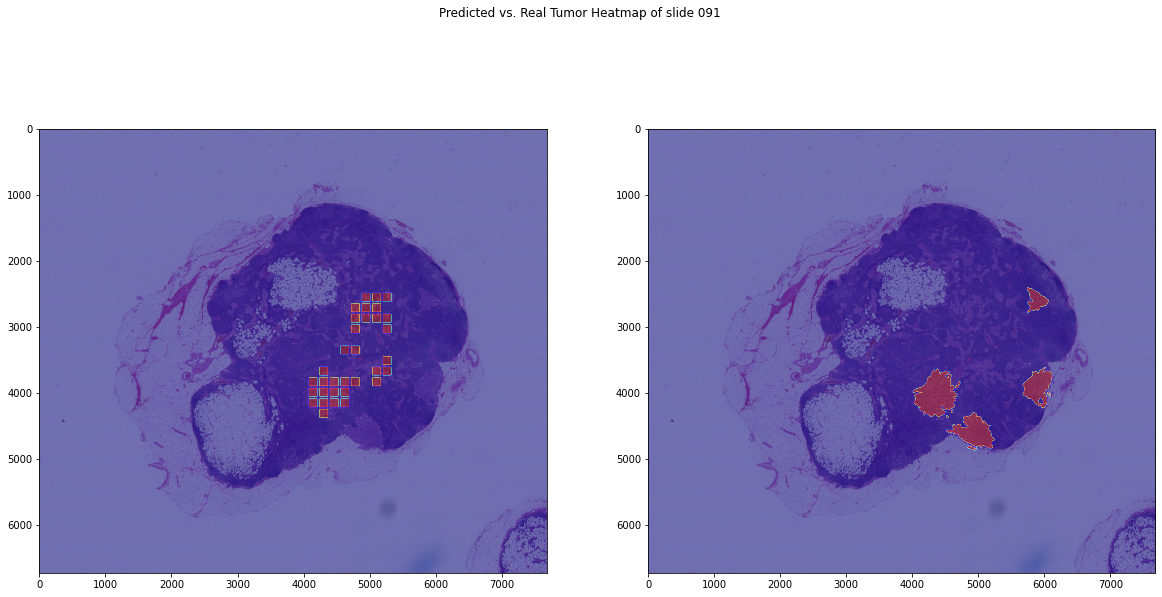


Label heatmap for 075
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075.tif with width: 11264, height: 9856
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075_mask.tif with width: 11264, height: 9856
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075.tif with width: 2816, height: 2464
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075_mask.tif with width: 2816, height: 2464
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075.tif with width: 704, height: 616
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075_mask.tif with width: 704, height: 616
The shape of predict_mask (9856, 11264)
The number of tumor of predict_mask 0.0
1.0 [[0.03490002]]
1.0 [[0.06327116]]
1.0 [[0.06772996]]
1.0 [[0.06005721]]
1.0 [[0.28715914]]
1.0 [[0.18072827]]
1.0 [[0.

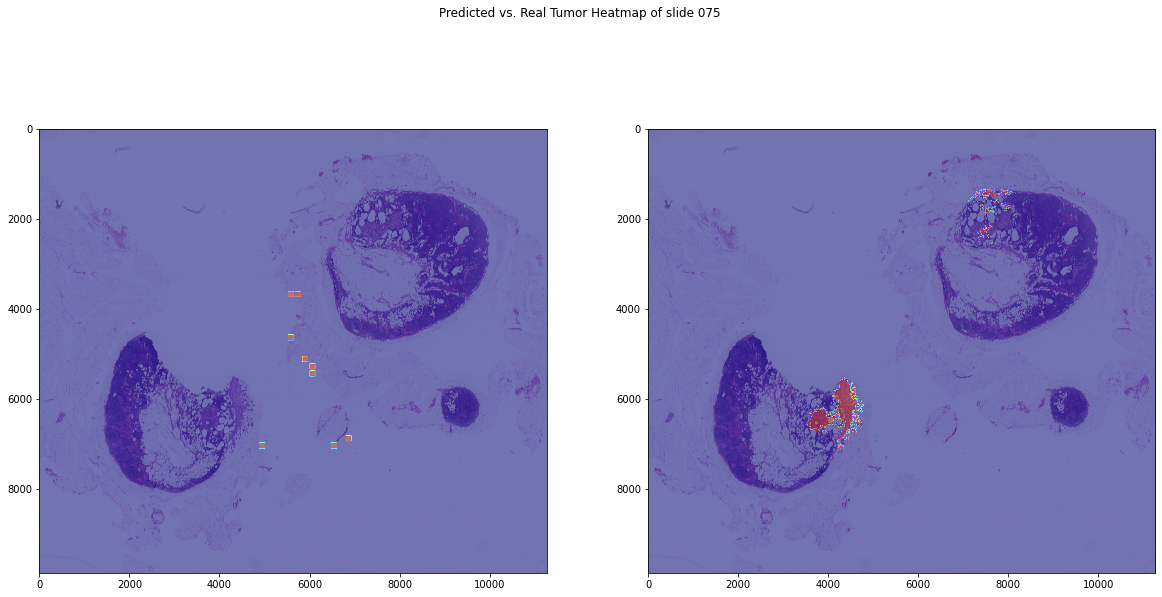


Label heatmap for 094
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094.tif with width: 14848, height: 12544
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094_mask.tif with width: 14848, height: 12544
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094.tif with width: 3712, height: 3136
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094_mask.tif with width: 3712, height: 3136
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094.tif with width: 928, height: 784
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094_mask.tif with width: 928, height: 784
The shape of predict_mask (12544, 14848)
The number of tumor of predict_mask 0.0
1.0 [[0.9251442]]
1.0 [[0.9761604]]
1.0 [[0.96080655]]
1.0 [[0.7976472]]
1.0 [[0.73511297]]
1.0 [[0.9824792]]
1.0 [[0.9

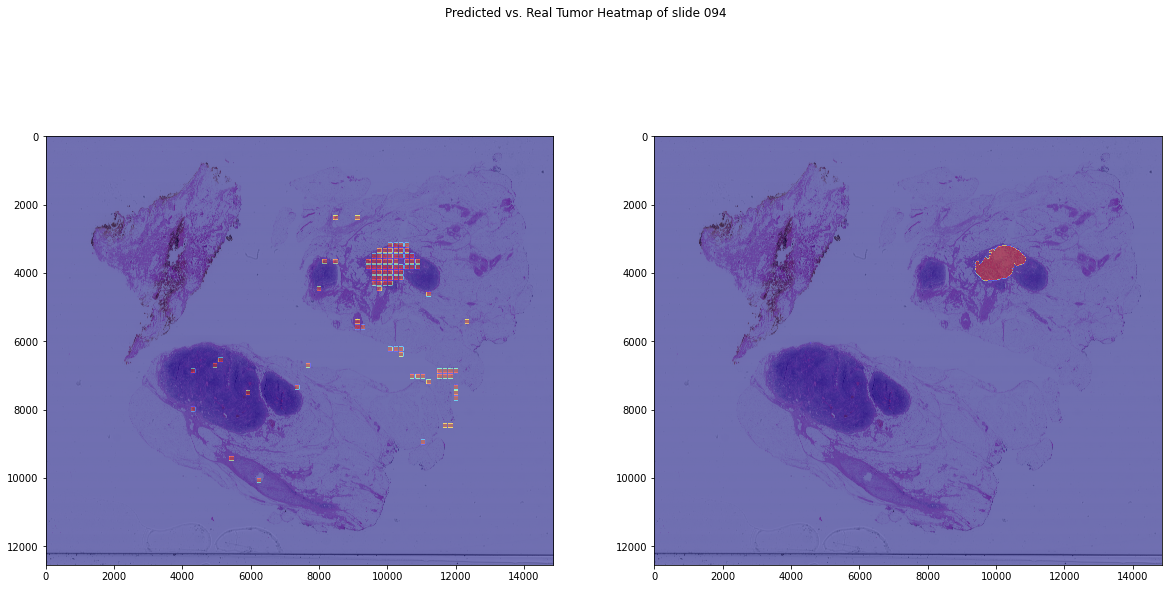


Label heatmap for 084
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084.tif with width: 8192, height: 10752
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084_mask.tif with width: 8192, height: 10752
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084.tif with width: 2048, height: 2688
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084_mask.tif with width: 2048, height: 2688
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084.tif with width: 512, height: 672
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084_mask.tif with width: 512, height: 672
The shape of predict_mask (10752, 8192)
The number of tumor of predict_mask 0.0
1.0 [[0.08242399]]
1.0 [[0.09821491]]
1.0 [[0.9098667]]
1.0 [[0.4810209]]
1.0 [[0.58278763]]
1.0 [[0.21777135]]
1.0 [[0.42

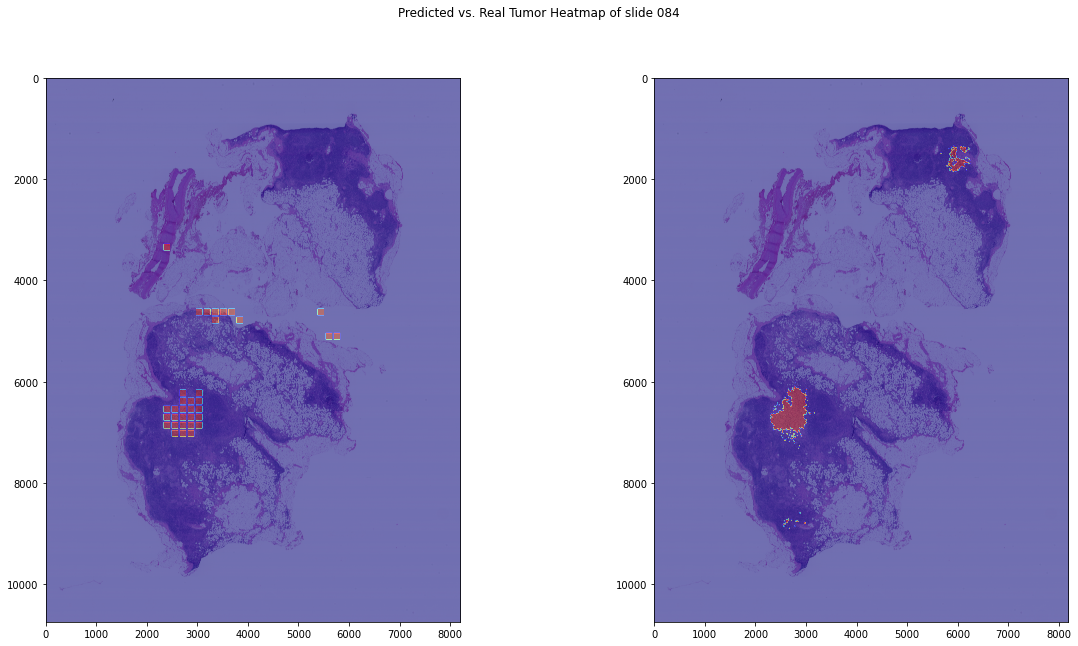

In [19]:
for slide_num in test_file:
  print("\nLabel heatmap for", slide_num)
  
  level_lst = [3, 5, 7]
  multi_slide_images = []
  multi_mask_images = []
  for level in level_lst:
    slide_image = read_full_image(slide_num, level=level, ifmask=False)
    mask_image = read_full_image(slide_num, level=level, ifmask=True)
    multi_slide_images.append(slide_image)
    multi_mask_images.append(mask_image)

  predict_mask = np.zeros(multi_mask_images[0].shape, dtype=float)
  print("The shape of predict_mask", predict_mask.shape)
  print("The number of tumor of predict_mask", predict_mask.sum())

  predict_mask = label_heatmap_multizooms(
      multi_slide_images, multi_mask_images, predict_mask, 
      threshold=0.5, step=10, pred_level=3, patch_len=299, 
      show_res=True, verbose=0)
  print("The number of tumor of predict_mask after labeling", predict_mask.sum())
  
  f, axarr = plt.subplots(1,2) 
  f.set_figheight(10)
  f.set_figwidth(20)
  f.suptitle(f'Predicted vs. Real Tumor Heatmap of slide {slide_num}')
  axarr[0].imshow(multi_slide_images[0])
  axarr[0].imshow(predict_mask, cmap='jet', alpha=0.5)
  axarr[1].imshow(multi_slide_images[0])
  axarr[1].imshow(multi_mask_images[0], cmap='jet', alpha=0.5)
  plt.show()